In [1]:
from src.models.BaseAutoEncoder import BaseSeq2Seq
from src.preprocess import split_train_valid_test
from src.dataload.window_based import WindowBasedDataset
from src.trainer import BaseTrainer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 100,
    'early_stop_round': 20,
    'hidden_size': 2,
    'window_size': 60
}

# gpu
gpu_id = 0 if torch.cuda.is_available() else -1

if gpu_id == 0:
    config['device'] = 'cuda:0'
else:
    config['device'] = 'cpu'

config = Namespace(**config)

print(config)

Namespace(batch_size=256, device='cuda:0', early_stop_round=20, hidden_size=2, n_epochs=100, train_ratio=0.8, window_size=60)


In [3]:
PATH = "./UCR_Anomaly_FullData/"
data_name = '001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620'

train_x, valid_x, test_x, train_y, valid_y, test_y = split_train_valid_test(PATH, data_name, config.train_ratio)

In [4]:
print(f'train_x.shape : {train_x.shape}')
print(f'train_y.shape : {train_y.shape}')
print(f'valid_x.shape : {valid_x.shape}')
print(f'valid_y.shape : {valid_y.shape}')
print(f'test_x.shape  : {test_x.shape}')
print(f'test_y.shape  : {test_y.shape}')

train_x.shape : (28000,)
train_y.shape : (28000,)
valid_x.shape : (7000,)
valid_y.shape : (7000,)
test_x.shape  : (44795,)
test_y.shape  : (44795,)


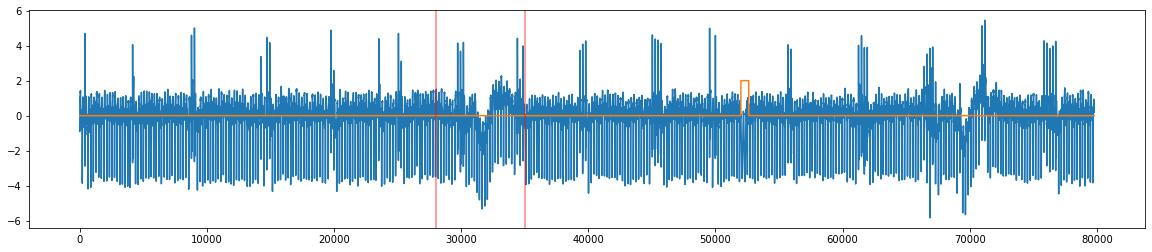

In [5]:
total_x = np.concatenate([train_x, valid_x, test_x])
total_y = np.concatenate([train_y, valid_y, test_y])

plt.figure(figsize=(20,4))
plt.plot(total_x)
plt.plot(total_y * 2)
plt.axvline(x = len(train_x) - 1, color='r', alpha=0.5)
plt.axvline(x = len(train_x) + len(valid_x) - 2, color='r', alpha=0.5)

In [6]:
train_dataset = WindowBasedDataset(train_x, train_y, config.window_size)
valid_dataset = WindowBasedDataset(valid_x, valid_y, config.window_size)
test_dataset = WindowBasedDataset(test_x, test_y, config.window_size)

In [7]:
train_dataloader = DataLoader(
    train_dataset, shuffle=False, batch_size=config.batch_size
)
valid_dataloader = DataLoader(
    valid_dataset, shuffle=False, batch_size=config.batch_size
)
test_dataloader = DataLoader(
    test_dataset, shuffle=False, batch_size=config.batch_size
)

In [8]:
model = BaseSeq2Seq(
    input_size=config.window_size,
    hidden_size=config.hidden_size,
    output_size=config.window_size,
    dropout_p=0.2,
).to(config.device)

optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [9]:
trainer = BaseTrainer(
    model=model,
    optimizer=optimizer,
    crit=criterion
)

best_model = trainer.train(
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    config=config,
    use_wandb=False
)

Epoch10/100: train_loss=0.456, valid_loss=0.441
Epoch20/100: train_loss=0.414, valid_loss=0.420
Epoch30/100: train_loss=0.392, valid_loss=0.418
Epoch40/100: train_loss=0.386, valid_loss=0.403
Epoch50/100: train_loss=0.371, valid_loss=0.396
Epoch60/100: train_loss=0.369, valid_loss=0.400
Epoch70/100: train_loss=0.360, valid_loss=0.389
Epoch80/100: train_loss=0.356, valid_loss=0.387
Epoch90/100: train_loss=0.356, valid_loss=0.388
Epoch100/100: train_loss=0.359, valid_loss=0.378


## check reconstruction

In [10]:
total_dataset = WindowBasedDataset(total_x, total_y, config.window_size)

total_dataloader = DataLoader(
    total_dataset, shuffle=False, batch_size=config.batch_size
)

In [11]:
best_model.to('cpu')

idx = 0
window_anomaly_score_result = np.zeros(len(total_x) - config.window_size + 1)
best_model.eval()
with torch.no_grad():
    for input_x, _ in total_dataloader:
        input_x = input_x
        input_x_batch_size = input_x.shape[0]
        y_hat = best_model(input_x)
        anomaly_score = abs(input_x - y_hat)
        window_anomaly_score = torch.mean(anomaly_score, 1).numpy()
        window_anomaly_score_result[idx:idx+input_x_batch_size] += window_anomaly_score
        idx += input_x_batch_size

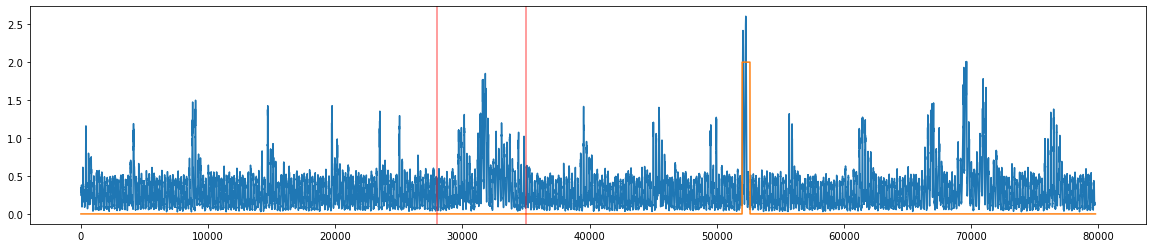

In [12]:
plt.figure(figsize=(20,4))
plt.plot(window_anomaly_score_result)
plt.plot(total_y * 2)
plt.axvline(x = len(train_x) - 1, color='r', alpha=0.5)
plt.axvline(x = len(train_x) + len(valid_x) - 2, color='r', alpha=0.5)

In [16]:
from src.utils import get_score

threshold = 1.5

get_score(
    total_y[:len(window_anomaly_score_result)],
    np.where(window_anomaly_score_result > threshold, 1, 0),
    window_anomaly_score_result
)

accuracy_score = 0.992
precision_score = 0.439
recall_score = 0.297
roc_auc_score = 0.727


## latent space viz

In [14]:
encoder = best_model.encoder

idx = 0
latent_space = np.zeros((len(total_x) - config.window_size + 1, 2))
encoder.eval()
with torch.no_grad():
    for input_x, _ in total_dataloader:
        input_x = input_x
        input_x_batch_size = input_x.shape[0]
        z = encoder(input_x).numpy()
        latent_space[idx:idx+input_x_batch_size, :] += z
        idx += input_x_batch_size

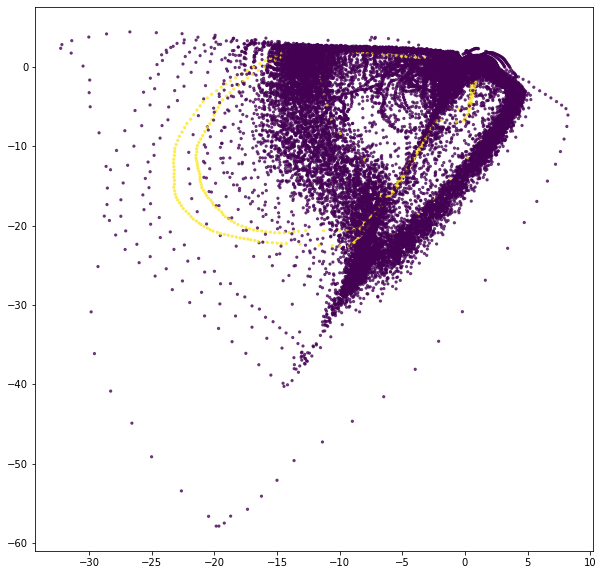

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(
    latent_space[:, 0], latent_space[:, 1],
    c=total_y[:len(latent_space)], s=5, alpha=0.7)